# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [143]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv

In [144]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [145]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("./Data/neighborhoods_coordinates.csv")
coordinates_df = pd.read_csv(file_path)



neighborhood_mean_df = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean().reset_index()
#neighborhood_mean_df.head()
combined_df = pd.concat([neighborhood_mean_df, coordinates_df], axis='columns', join='inner').dropna()
combined_df.drop(columns=['Neighborhood'], inplace=True)
#combined_df.head()

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [146]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units_mean = sfo_data[['housing_units']].groupby([sfo_data.index])['housing_units'].mean()
    mins = housing_units_mean.min()
    maxes = housing_units_mean.max()
    std = housing_units_mean.std()
    housing_units_mean.plot.bar(title='Housing Units in San Francisco from 2010 to 2016')
    plt.ylabel('Housing Units')
    plt.ylim(mins - std, maxes + std)
    return plt


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    sfo_avg_price_rent_df = sfo_data[['sale_price_sqr_foot','gross_rent']].groupby([sfo_data.index])['sale_price_sqr_foot','gross_rent'].mean()
    sfo_avg_price_rent_df.reset_index().plot(x='year', y='gross_rent', title='Average Gross Rent by Year',color='red')
    plt.ylabel('Gross Rent')
    return plt



def average_sales_price():
    """Average Sales Price Per Year."""
    sfo_avg_price_rent_df = sfo_data[['sale_price_sqr_foot','gross_rent']].groupby([sfo_data.index])['sale_price_sqr_foot','gross_rent'].mean()
    sfo_avg_price_rent_df.reset_index().plot(x='year', y='sale_price_sqr_foot', title='Average Price per SqFt by Year',color='purple')
    plt.ylabel('Price per SqFt')
    return plt



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sfo_avg_price_by_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean().reset_index()
    plot = sfo_avg_price_by_neighborhood.hvplot(x='year', y=['sale_price_sqr_foot'], groupby="neighborhood", ylabel='Avg. price', subplots=True, width=700, height=300)
    return plot


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    df_expensive_neighborhoods = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean()
    df_expensive_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index().head(10)
    return df_expensive_neighborhoods.hvplot.bar(x='neighborhood', y='sale_price_sqr_foot', ylabel='Avg. Sale Price per Square Foot', xlabel='Neighborhood', rot=90, width=800, height=500)


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    sfo_avg_price_by_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean().reset_index()
    sfo_avg_price_by_neighborhood.sort_values(['sale_price_sqr_foot','gross_rent'], inplace=True, ascending=False)
    return sfo_avg_price_by_neighborhood.hvplot.bar(x='year', y=['sale_price_sqr_foot', 'gross_rent'], xlabel='Year', ylabel='Avg price, Gross rent', groupby='neighborhood', rot=90, width=700, height=400)

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    sfo_avg_price_by_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean().reset_index()
    df_expensive_neighborhoods = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean()
    df_expensive_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index().head(10)
    df_expensive_neighborhoods_per_year = sfo_avg_price_by_neighborhood[sfo_avg_price_by_neighborhood["neighborhood"].isin(df_expensive_neighborhoods["neighborhood"])]
    return px.parallel_coordinates(df_expensive_neighborhoods, color='sale_price_sqr_foot')    



def parallel_categories():
    """Parallel Categories Plot."""
    sfo_avg_price_by_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean().reset_index()
    df_expensive_neighborhoods = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean()
    df_expensive_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index().head(10)
    df_expensive_neighborhoods_per_year = sfo_avg_price_by_neighborhood[sfo_avg_price_by_neighborhood["neighborhood"].isin(df_expensive_neighborhoods["neighborhood"])]
    plot = px.parallel_categories(
        df_expensive_neighborhoods,
        dimensions=['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'],
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            'neighborhood': 'neighborhood',
            'sale_price_sqr_foot': 'sale_price_sqr_foot',
            'housing_units': 'housing_units',
            'gross_rent': 'gross_rent'
        },
    )
    return plot



def neighborhood_map():
    """Neighborhood Map."""
    # Create a scatter mapbox to analyze neighborhood info
    map_plot = px.scatter_mapbox(
    combined_df,
    lat='Lat',
    lon='Lon',
    size='sale_price_sqr_foot',
    hover_name='neighborhood',
    title='Averange Sale Price Per Square Foot and Gross Rent in San Francisco',
    color='gross_rent',
    zoom=10
)
    return map_plot


def sunburst():
    """Sunburst Plot."""
    
    sfo_avg_price_by_neighborhood = sfo_data.groupby([sfo_data.index,'neighborhood']).mean().reset_index()
    df_expensive_neighborhoods = sfo_data.groupby(['neighborhood'])['sale_price_sqr_foot', 'housing_units', 'gross_rent'].mean()
    df_expensive_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending=False, inplace=True)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index().head(10)
    df_expensive_neighborhoods_per_year = sfo_avg_price_by_neighborhood[sfo_avg_price_by_neighborhood["neighborhood"].isin(df_expensive_neighborhoods["neighborhood"])]
    plot = px.sunburst(df_expensive_neighborhoods_per_year, path=['year','neighborhood'], color='gross_rent', color_continuous_scale='Blues')
    return plot

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

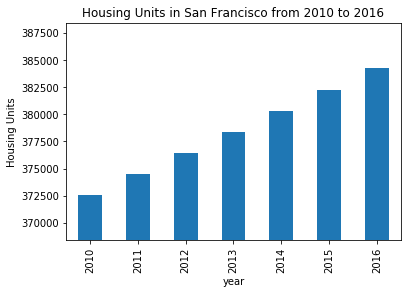

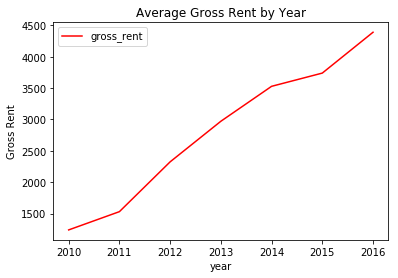

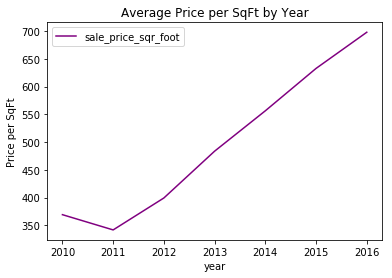

In [147]:
# Create a Title for the Dashboard
# Create a tab layout for the dashboard

market_analysis = pn.Column("## Yearly Market Analysis", housing_units_per_year(), average_gross_rent(), average_sales_price())
neighborhood_analysis = pn.Column("## Neighborhood Analysis",  average_price_by_neighborhood(), top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())
parallel_plot_analysis = pn.Column("## Parallel Plot Analysis", parallel_categories(), parallel_coordinates())
sunburst_plot_analysis = pn.Column("## Sunburst Plot Analysis", sunburst())


# Create the dashboard
dashboard = pn.Tabs(
    ("Market Analysis",market_analysis),
    ("Neighborhood Analysis",neighborhood_analysis),
    ("Parallel Plot Analysis",parallel_plot_analysis),
    ("Sunburst Plot Analysis",sunburst_plot_analysis)
)
    


## Serve the Panel Dashboard

In [148]:
# Serve the# dashboard
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(module)
        [2] Str(module)
        [3] Str(module)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Union Square District', ...], value='Union Square District', width=250)
                [1] VSpacer()
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure, visible=False)
        [2] Plotly(Figure, visible=False)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure, visible=False)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

<module 'matplotlib.pyplot' from '/Users/jinhyeongpark/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

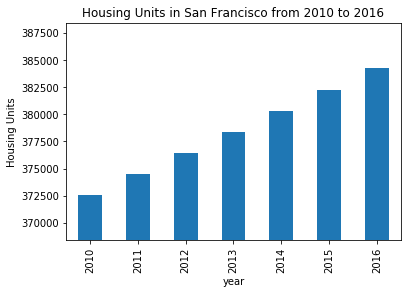

In [149]:
housing_units_per_year()

<module 'matplotlib.pyplot' from '/Users/jinhyeongpark/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

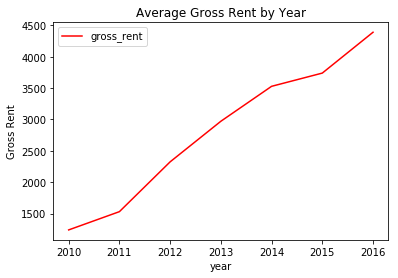

In [150]:
average_gross_rent()

<module 'matplotlib.pyplot' from '/Users/jinhyeongpark/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

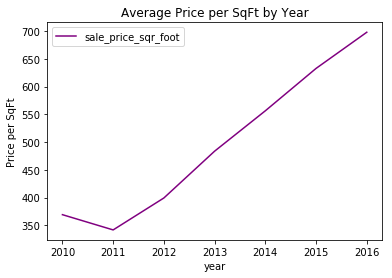

In [151]:
average_sales_price()

In [152]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [153]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [154]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

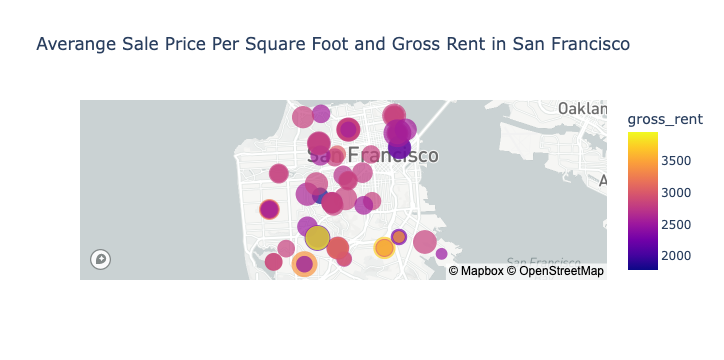

In [155]:
neighborhood_map().show()

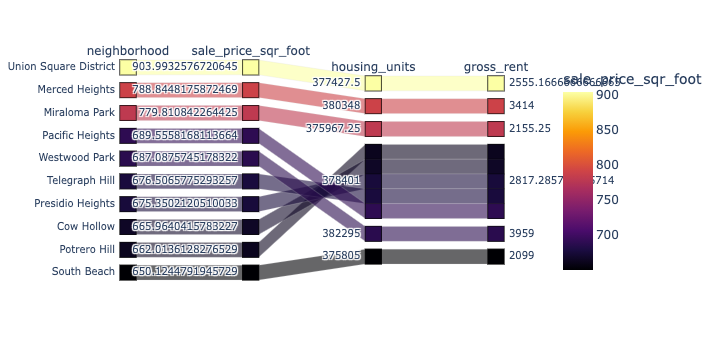

In [156]:
parallel_categories()

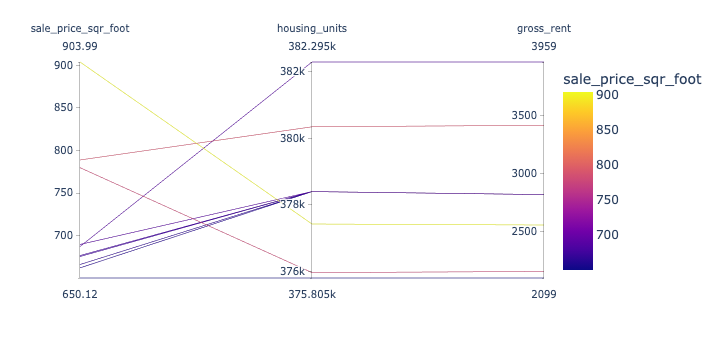

In [157]:
parallel_coordinates()

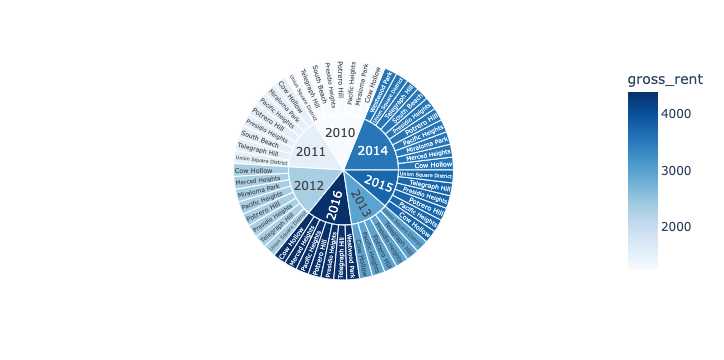

In [158]:
sunburst()